<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/CHR%20and%20Fuzzy%20PID%20controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

пример кода для работы с ПИД регулятором

In [1]:
!pip install control -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 11.5 MB/s eta 0:00:00


https://robotics.stackexchange.com/questions/4901/how-to-tune-the-pid-parameters-using-fuzzy-logic

# Plant system

In [2]:
import control
import numpy as np

#передаточная функция: числитель и знаменатель
num = np.array([1])
den = np.array([3, 1, 1])
W = control.tf(num, den)
print('W(s) = ', W)

W(s) =  <TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        1
  -------------
  3 s^2 + s + 1


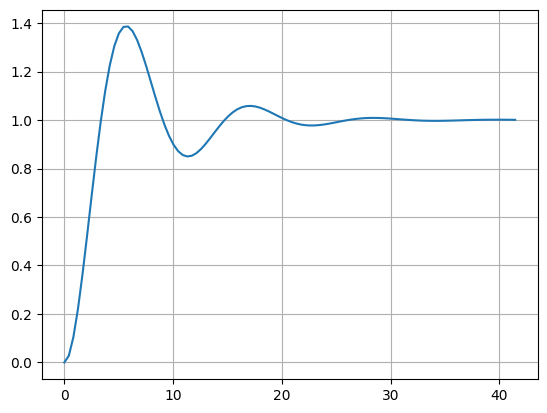

In [3]:
# реакция на ступенчатое воздействие

t, y = control.step_response(W)
import matplotlib.pyplot as plt
plt.plot(t,y)
plt.grid(True)


In [4]:
# начальные (инициация) настройки ПИД регулятора
Kp = 1
Ki = 1
Kd = 1
Wpid = Kp + Ki * control.tf(1, np.array([1, 0])) + Kd * control.tf(np.array([1, 0]), 1)

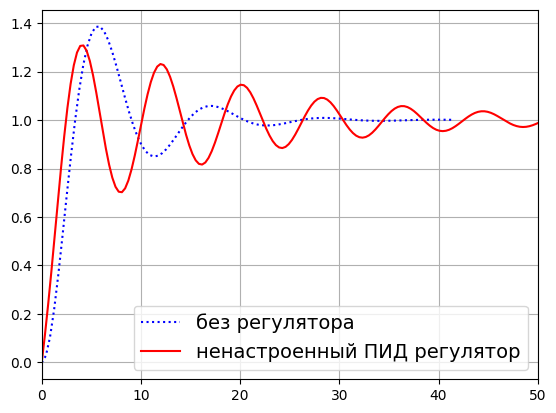

In [5]:
# проверяем реакцию системы с нестроенным ПИД-реглятором
Wopt = Wpid*W / (1 + Wpid*W)
tpid, ypid = control.step_response(Wopt)
plt.plot(t, y, ':b', label = 'без регулятора')
plt.plot(tpid, ypid, 'r', label = 'ненастроенный ПИД регулятор')
plt.xlim(0, 50)
plt.grid(True)
plt.legend(fontsize=14)

# CHR = Chein - Hrones - Reswick

параметры настройки CHR = Chein - Hrones -Reswick

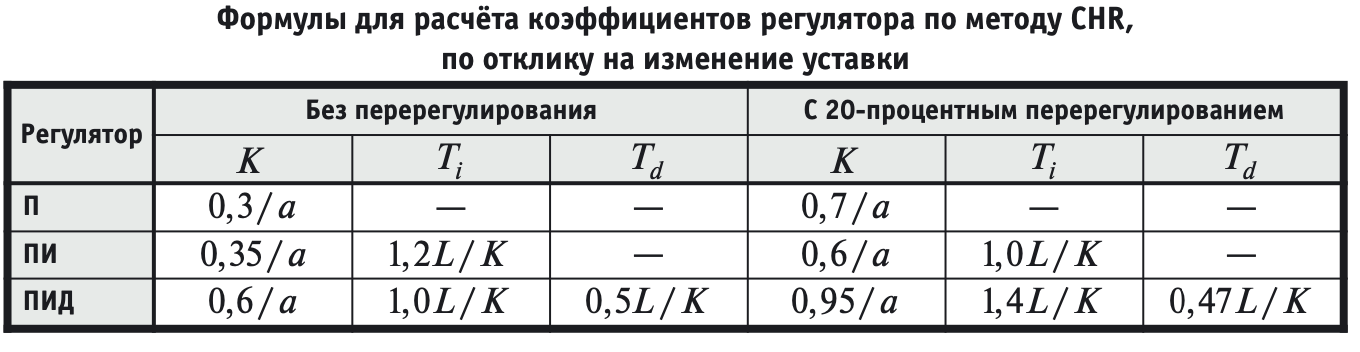

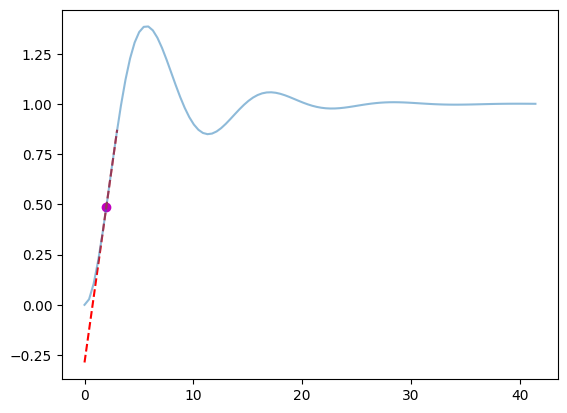

In [6]:
from scipy import interpolate

def draw_tangent(x,y,a):
 # interpolate the data with a spline
 spl = interpolate.splrep(x,y)
 small_t = np.arange(a-2,a+2)
 fa = interpolate.splev(a,spl,der=0)     # f(a)
 fprime = interpolate.splev(a,spl,der=1) # f'(a)
 tan = fa+fprime*(small_t-a) # tangent
 plt.plot(a,fa,'om',small_t,tan,'--r')

draw_tangent(t,y,2)

plt.plot(t,y, alpha=0.5)
plt.show()

In [7]:
!pip install PyAstronomy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 7.4 MB/s eta 0:00:00


In [8]:
from PyAstronomy import pyaC

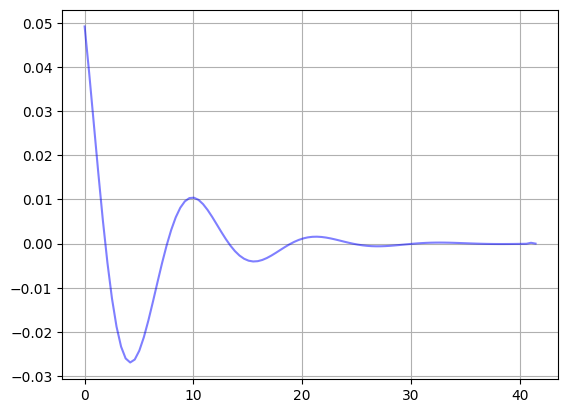

In [9]:
dydt = np.diff(y, append = y[-1])
d2ydt2 = np.diff(dydt, append = dydt[-1])
plt.plot(t, d2ydt2, 'b', alpha = 0.5)
plt.grid()

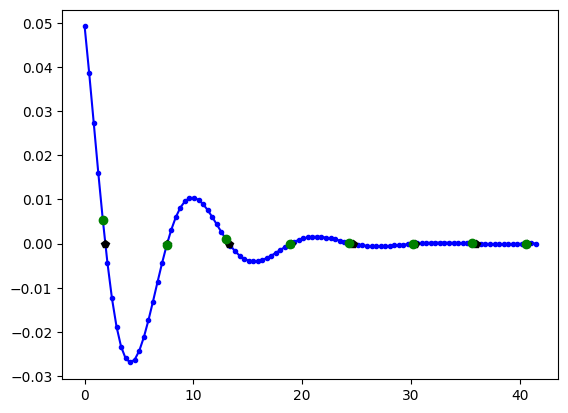

In [10]:
xc, xi = pyaC.zerocross1d(t, d2ydt2, getIndices=True)

# Plot the data
plt.plot(t, d2ydt2, 'b.-')
# Add black points where the zero line is crossed
plt.plot(xc, np.zeros(len(xc)), 'kp')
# Add green points at data points preceding an actual
# zero crossing.
plt.plot(t[xi], d2ydt2[xi], 'go')
plt.show()

1.9053121790506578


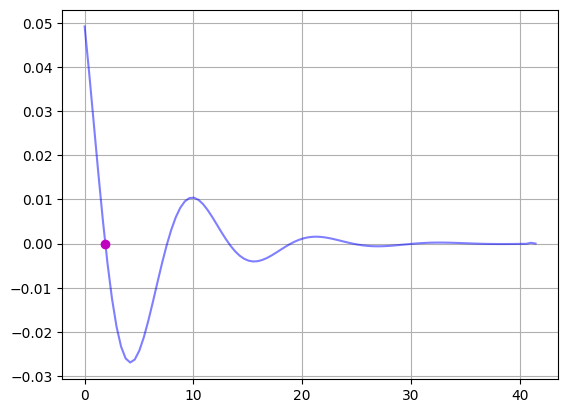

In [11]:
dydt = np.diff(y, append = y[-1])
d2ydt2 = np.diff(dydt, append = dydt[-1])
plt.plot(t, d2ydt2, 'b', alpha = 0.5)
plt.plot(xc[0], 0, 'om')
plt.grid()
print(xc[0])

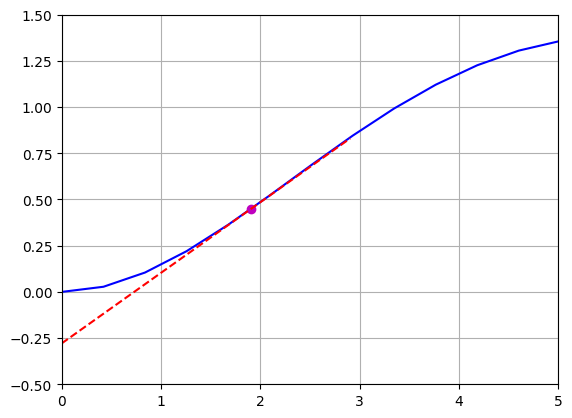

In [12]:
# определяем параметы а и L

plt.plot(t, y, 'b', label = 'без регулятора')
plt.xlim(0, 5)
plt.ylim(-0.5, 1.5)
plt.grid(True)

draw_tangent(t,y,xc[0])

In [13]:
# настройка ПИД регулятора методом CHR (Chien, Hrones и Reswick)
a = 0.25
L = 0.7
Kp = 0.6 * a
Ki = (1.0 * L / Kp) ** -1
Kd = 0.5 * L / Kp
Wpid = Kp + Ki * control.tf(1,np.array([1, 0])) + Kd * control.tf(np.array([1, 0]), 1)

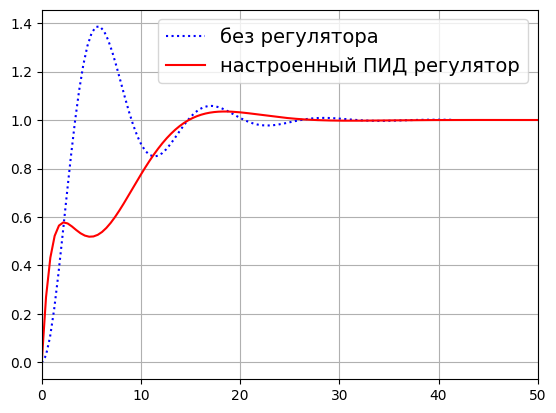

In [14]:
# проверяем реакцию системы с настроенным ПИД-реглятором
Wopt = Wpid*W / (1 + Wpid*W)
tpid, ypid = control.step_response(Wopt)
plt.plot(t, y, ':b', label = 'без регулятора')
plt.plot(tpid, ypid, 'r', label = 'настроенный ПИД регулятор')
plt.xlim(0, 50)
plt.grid(True)
plt.legend(fontsize=14)

# prepare for Fuzzy

In [15]:
!pip install scikit-fuzzy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.5 MB/s eta 0:00:00


In [155]:
class pidcont():
    def __init__(self,P,I,D,pmax,pmin):
        self.kp=P
        self.kd=D
        self.ki=I
        self.pidmax=pmax
        self.pidmin=pmin
        self.desired=0.0
        self.error=0.0
        self.elast=0.0
        self.esum=0.0
        self.eder=0.0
    def update(self,current):
        self.error=self.desired-current
        self.eder=self.error-self.elast
        self.esum=self.esum+self.error
        self.elast=self.error

        if self.esum>self.pidmax:
            self.esum=self.pidmax
        elif self.esum<self.pidmin:
            self.esum=self.pidmin

        self.P = self.kp * self.error
        self.D = self.kd * self.eder
        self.I = self.ki * self.esum
        pid = self.P + self.I + self.D #общая ошибка выхода ПИД регулятора
        return pid
    def setDesired(self,d):
        self.desired = d
    def setGains(self,P,I,D):
        self.kp = P
        self.kd = D
        self.ki = I
    def setLimits(self,pmax,pmin):
        self.pidmax = pmax
        self.pidmin = pmin

In [145]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
from matplotlib import pyplot as plt

In [146]:
# определяем входные (анцендент) и выходные (консеквент) нечеткие переменные
ferr = ctrl.Antecedent(np.arange(-1, 1, 0.01), 'ferr')
fder = ctrl.Antecedent(np.arange(-1, 1, 0.01), 'fder')
fout = ctrl.Consequent(np.arange(-1, 1, 0.01), 'fout')

In [147]:
# создаем автоматически встроенной функцией юниверс и определяем логические переменные
# их 3, 5 или 7 может быть, если использовать встроенную функцию automf
# по умолчанию лингвистические переменные: poor, avarage, good
ferr.automf(3)
fder.automf(3)

In [148]:
# определяем лингвистические переменные выхода
fout['NB'] = fuzz.trimf(fout.universe, [-1, -1, -0.5]) #negetive big
fout['NS'] = fuzz.trimf(fout.universe, [-1, -0.5, 0])
fout['Z'] = fuzz.trimf(fout.universe, [-0.1, 0, 0.1])
fout['PS'] = fuzz.trimf(fout.universe, [0, 0.5, 2])
fout['PB'] = fuzz.trimf(fout.universe, [0.5, 1, 1]) #positive big

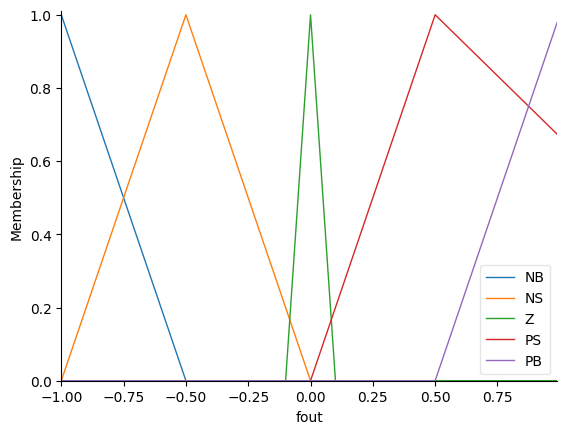

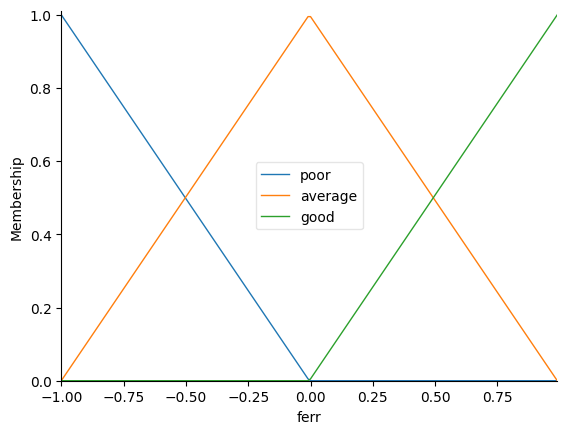

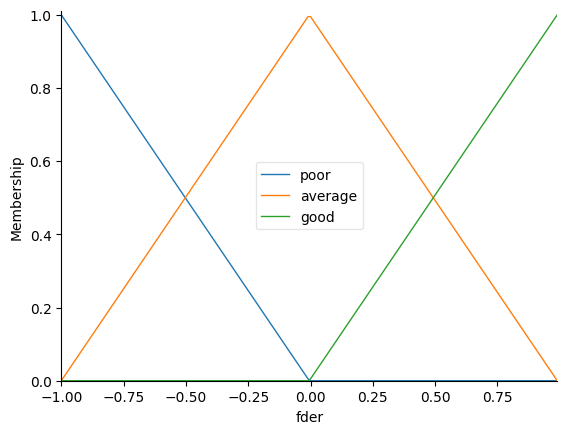

In [149]:
#готовим окно для вывода графиков
fout.view()
ferr.view()
fder.view()

In [156]:
# задаем базу правил для нечеткого вывода
rules=[]
rules.append(ctrl.Rule(ferr['poor'] & fder['poor'] , fout['NB']))
rules.append(ctrl.Rule(ferr['poor'] & fder['average'] , fout['NB']))
rules.append(ctrl.Rule(ferr['poor'] & fder['good'] , fout['NS']))
rules.append(ctrl.Rule(ferr['average'] & fder['poor'] , fout['NS']))
rules.append(ctrl.Rule(ferr['average'] & fder['average'] , fout['Z']))
rules.append(ctrl.Rule(ferr['average'] & fder['good'] , fout['PS']))
rules.append(ctrl.Rule(ferr['good'] & fder['poor'] , fout['PS']))
rules.append(ctrl.Rule(ferr['good'] & fder['average'] , fout['PB']))
rules.append(ctrl.Rule(ferr['good'] & fder['good'] , fout['PB']))

In [157]:
#ctrl.ControlSystemSimulation refers to a class within the skfuzzy.control module in the skfuzzy library for Python.
#This class is used to simulate a fuzzy control system that has been defined using ctrl.ControlSystem.

fctrl = ctrl.ControlSystem(rules) #определяем переменную специальную fctrl
fpid = ctrl.ControlSystemSimulation(fctrl) #нечеткий вывод и дефазицикация Мамдани

# class Fuzzy

In [158]:
# инициируем класс ПИД регуляторов: П, И и Д
# входная (Кp,Ki,Kd,pmax,pmin):
#erpid_fuz = pidcont(1.2,0.02,0.01,5,-5) #нечеткий ПИД
#erpid_nonfuz = pidcont(1.2,0.02,0.01,5,-5) #четкий ПИД

erpid_fuz    = pidcont(Kp,Kd,Ki,50,-50) #четкий ПИД
erpid_nonfuz = pidcont(Kp,Kd,Ki,50,-50) #четкий ПИД

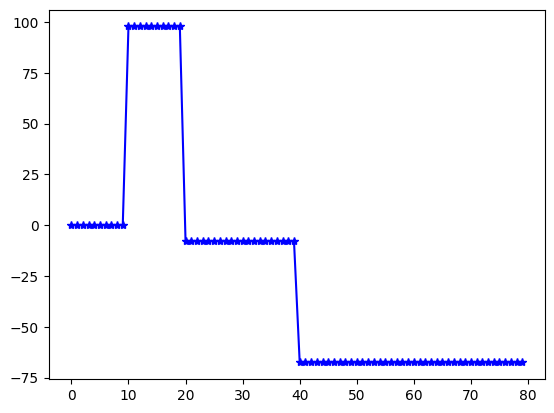

In [159]:
# задаем 5 участков (желаемое значение регулирования на входе)
d = []
d = np.zeros(10)
np.random.seed(37)
for i in range(3):
    d = np.append(d,np.ones(len(d))*np.random.uniform(-110,110,1))
plt.plot(d,'*-b')

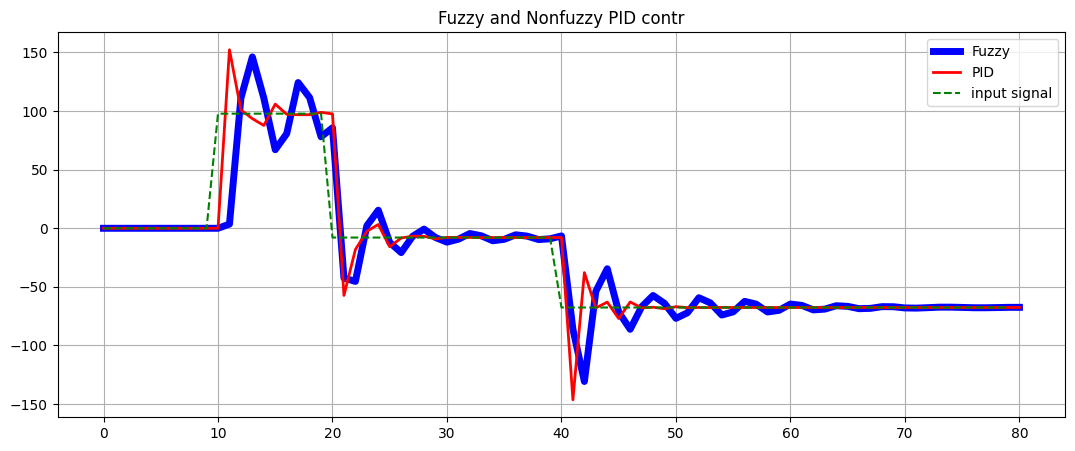

In [160]:
# задаем начальные условия
y_fuz = []
y_fuz.append(0.0)
y_nonfuz = []
y_nonfuz.append(0.0)
e_fuz = []
de_fuz = []
e_nonfuz = []
de_nonfuz = []

kp = erpid_fuz.kp
kd = erpid_fuz.kd
ki = erpid_fuz.ki


fig = plt.figure(figsize=(13, 5))
plt.grid()
#ax.set_xlim([0, len(d)])

for i in range(len(d)):
    # формируем нечеткий ПИД регулятор
    erpid_fuz.setDesired(d[i]) # установили желаемое значение
    fpid.input['ferr'] = erpid_fuz.error # фазифицируем значение ошибки
    fpid.input['fder'] = erpid_fuz.eder # фазифицируем значение скорости ошибки
    fpid.compute() # генерируем выход нечеткого контроллера
    newpid = np.abs(fpid.output['fout']) # считаем нечеткий выход из контроллера
    erpid_fuz.setGains(newpid * kp, newpid * ki, newpid * kd) # выход умножаем на коэффициенты
    newy = erpid_fuz.update(y_fuz[-1]) # обновить оценку, аргумент - последний элемент массива
    newy = y_fuz[-1] + newy
    y_fuz.append(newy) # формируем массив рассогласований
    e_fuz.append(erpid_fuz.error) # формируем массив ошибок
    de_fuz.append(erpid_fuz.eder) # формируем массив прозводнных ошибок

    erpid_nonfuz.setDesired(d[i]) # четкий ПИД
    newynf = erpid_nonfuz.update(y_nonfuz[-1])
    newynf = y_nonfuz[-1] + newynf
    y_nonfuz.append(newynf)
    e_nonfuz.append(erpid_nonfuz.error)
    de_nonfuz.append(erpid_nonfuz.eder)


plt.plot(range(len(y_fuz)), y_fuz, 'b', linewidth=5.0, label='Fuzzy')
plt.plot(range(len(y_nonfuz)), y_nonfuz, 'r', linewidth=2.0, label='PID')
plt.plot(range(len(d)),d,'g--', label='input signal')
#plt.plot(range(len(e_nonfuz)),e_nonfuz,'r-')

plt.title('Fuzzy and Nonfuzzy PID contr')
plt.legend()

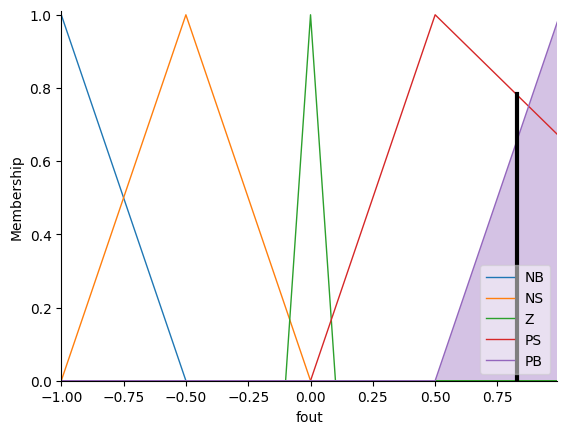

In [161]:
fpid.input['ferr'] = +10 # фазифицируем значение ошибки
fpid.input['fder'] = +100 # фазифицируем значение скорости ошибки
fpid.compute()
fout.view(sim = fpid)

# Анимированное изображение - пример

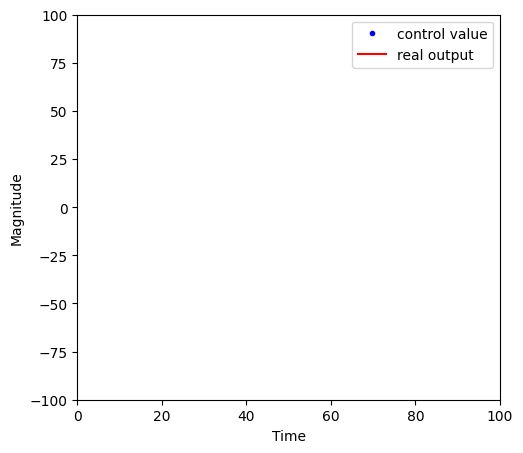

In [89]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)

# set up the subplots as needed
ax1.set_xlim(( 0, 100))
ax1.set_ylim((-100, 100))
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
line1, = ax1.plot([], [], '.b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot([], [], '-r', ms=2)

ax1.legend(['control value','real output']);

In [90]:
# animation function. This is called sequentially
def drawframe(n):
    x = np.linspace(0, 100, len(d))
    #y = np.cos(2 * np.pi * (x - 0 * n))
    y = d
    line1.set_data(x, y)
    line2.set_data(x[:n], y[:n])
    #pt1.set_data(y1[0],y2[0])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (line1, line2)

In [91]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=100, blit=True)

In [92]:
from IPython.display import HTML
HTML(anim.to_html5_video())

# Compare Fuzzy and CHR PID

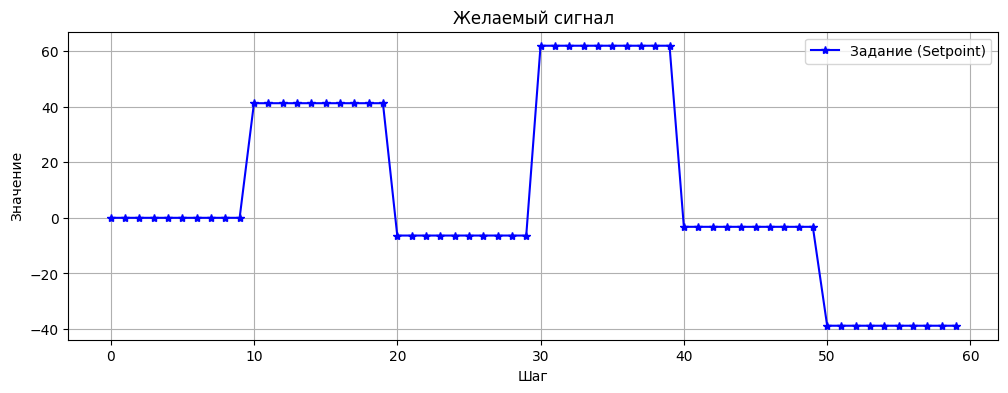

Передаточная функция объекта W(s) = <TransferFunction>: sys[1403]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        1
  -------------
  3 s^2 + s + 1
Количество состояний объекта W: 2
Параметры PID (CHR): Kp=0.150, Ki=0.214, Kd=2.333
Передаточная функция PID (CHR) Wpid(s) = <TransferFunction>: sys[1410]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.3643 s + 0.2143
  -----------------
          s


In [186]:
import control
import control.matlab # Импортируем matlab для lsim
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import skfuzzy as fuzz

# --- Класс ПИД-регулятора из файла ---
class pidcont():
    def __init__(self, P, I, D, pmax, pmin):
        self.kp = P
        self.kd = D
        self.ki = I
        self.pidmax = pmax
        self.pidmin = pmin
        self.desired = 0.0
        self.error = 0.0
        self.elast = 0.0
        self.esum = 0.0
        self.eder = 0.0

    def update(self, current):
        self.error = self.desired - current
        self.eder = self.error - self.elast
        self.esum = self.esum + self.error
        self.elast = self.error

        if self.esum > self.pidmax:
            self.esum = self.pidmax
        elif self.esum < self.pidmin:
            self.esum = self.pidmin

        self.P = self.kp * self.error
        self.D = self.kd * self.eder
        self.I = self.ki * self.esum
        pid = self.P + self.I + self.D
        return pid # Возвращаем сигнал управления u

    def setDesired(self, d):
        self.desired = d

    def setGains(self, P, I, D):
        self.kp = P
        self.kd = D
        self.ki = I

    def setLimits(self, pmax, pmin):
        self.pidmax = pmax
        self.pidmin = pmin

# --- ЗАДАНИЕ ЖЕЛАЕМОГО СИГНАЛА (из вашего исходного кода) ---
d = np.zeros(10)
for i in range(5):
    d = np.append(d, np.ones(10) * np.random.uniform(-110, 110, 1))
time_d = np.arange(len(d)) # Время для сигнала d
plt.figure(figsize=(12, 4))
plt.plot(time_d, d, '*-b', label='Задание (Setpoint)')
plt.title('Желаемый сигнал')
plt.xlabel('Шаг')
plt.ylabel('Значение')
plt.grid(True)
plt.legend()
plt.show()

# --- ОПРЕДЕЛЕНИЕ ОБЪЕКТА УПРАВЛЕНИЯ (из файла) ---
num = np.array([1])
den = np.array([3, 1, 1])
W = control.tf(num, den)
print(f'Передаточная функция объекта W(s) = {W}')

# --- Получаем представление в пространстве состояний и определяем количество состояний ---
sys_ss = control.tf2ss(W)
n_states_W_fuzzy = sys_ss.A.shape[0] # Количество состояний
print(f"Количество состояний объекта W: {n_states_W_fuzzy}")

# --- НАСТРОЙКА КЛАССИЧЕСКОГО PID РЕГУЛЯТОРА МЕТОДОМ CHR (из файла) ---
a = 0.25
L = 0.7
Kp_chr = 0.6 * a
Ki_chr = (1.0 * L / Kp_chr) ** -1
Kd_chr = 0.5 * L / Kp_chr
print(f'Параметры PID (CHR): Kp={Kp_chr:.3f}, Ki={Ki_chr:.3f}, Kd={Kd_chr:.3f}')

# --- СОЗДАНИЕ НЕЧЕТКОГО PID РЕГУЛЯТОРА (на основе файла) ---
ferr = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'ferr') # Ошибка
fder = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'fder') # Производная ошибки
fout = ctrl.Consequent(np.arange(-1, 1, 0.1), 'fout') # Выход (модуляция коэффициентов)

ferr['poor'] = fuzz.trimf(ferr.universe, [-150, -150, 0])
ferr['average'] = fuzz.trimf(ferr.universe, [-150, 0, 150])
ferr['good'] = fuzz.trimf(ferr.universe, [0, 150, 150])

fder['poor'] = fuzz.trimf(fder.universe, [-150, -150, 0])
fder['average'] = fuzz.trimf(fder.universe, [-150, 0, 150])
fder['good'] = fuzz.trimf(fder.universe, [0, 150, 150])

fout['NB'] = fuzz.trimf(fout.universe, [-1, -1, -0.5]) # Negative Big
fout['NS'] = fuzz.trimf(fout.universe, [-0.5, -0.5, 0])  # Negative Small
fout['Z'] = fuzz.trimf(fout.universe, [-0.01, 0, 0.01])  # Zero
fout['PS'] = fuzz.trimf(fout.universe, [0, 0.5, 0.5])    # Positive Small
fout['PB'] = fuzz.trimf(fout.universe, [0.5, 1, 1])    # Positive Big

rules = [
    ctrl.Rule(ferr['poor'] & fder['poor'], fout['NB']),
    ctrl.Rule(ferr['poor'] & fder['average'], fout['NB']),
    ctrl.Rule(ferr['poor'] & fder['good'], fout['NS']),
    ctrl.Rule(ferr['average'] & fder['poor'], fout['NS']),
    ctrl.Rule(ferr['average'] & fder['average'], fout['Z']),
    ctrl.Rule(ferr['average'] & fder['good'], fout['PS']),
    ctrl.Rule(ferr['good'] & fder['poor'], fout['PS']),
    ctrl.Rule(ferr['good'] & fder['average'], fout['PB']),
    ctrl.Rule(ferr['good'] & fder['good'], fout['PB'])
]

fctrl = ctrl.ControlSystem(rules)
fpid_sim_base = ctrl.ControlSystemSimulation(fctrl) # Базовый экземпляр для правил

# --- ИНИЦИАЛИЗАЦИЯ ПИД-РЕГУЛЯТОРОВ ---
kp_fuz = Kp_chr
ki_fuz = Ki_chr
kd_fuz = Kd_chr
erpid_fuz = pidcont(kp_fuz, ki_fuz, kd_fuz, 5, -5)
erpid_nonfuz = pidcont(Kp_chr, Ki_chr, Kd_chr, 5, -5)

# --- СИМУЛЯЦИЯ С ИСПОЛЬЗОВАНИЕМ control.lsim ---
# Параметры симуляции
dt_sim = 1.0 # Шаг времени (соответствует дискретности сигнала d)
time_sim = np.arange(0, len(d)) * dt_sim

# --- 1. Симуляция системы W на входном сигнале d (открытый контур) ---
try:
    # Используем определенное количество состояний
    X0_open = np.zeros(n_states_W_fuzzy) # Вектор размерности (n_states_W_fuzzy,)

    # Симуляция: y_open_loop(t) = W(s) * d(t)
    t_out_open, y_open_loop, x_out_open = control.matlab.lsim(W, U=d, T=time_sim, X0=X0_open)

    # Проверка размеров для согласованности
    if len(y_open_loop) != len(d):
        y_open_loop = np.interp(time_sim, t_out_open, y_open_loop)

except Exception as e:
    print(f"Ошибка при симуляции открытой системы W: {e}")
    y_open_loop = np.zeros_like(d) # Заглушка

# --- 2. Симуляция замкнутых систем ---
# --- 2a. Симуляция замкнутой системы с классическим PID (CHR) ---
# Создаем передаточную функцию PID регулятора
num_pid_chr = [Kd_chr, Kp_chr, Ki_chr]
den_pid_chr = [1, 0] # 1/s
Wpid_chr_tf = control.tf([Kp_chr],[0, 1]) + control.tf([Ki_chr],[1]) + control.tf([Ki_chr],[1, 0])
print(f'Передаточная функция PID (CHR) Wpid(s) = {Wpid_chr_tf}')

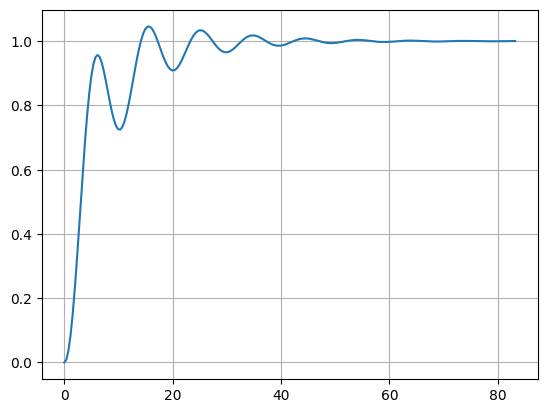

In [192]:
t, y = control.step_response(W_closed_chr_sensitivity)

plt.plot(t,y)
plt.grid(True)

In [193]:
try:
    # Передаточная функция от задания к выходу для замкнутой системы
    W_closed_chr_sensitivity = control.feedback(Wpid_chr_tf * W, 1) # Порядок: Wpid * W
    # Симуляция реакции на задание d
    # Определяем количество состояний замкнутой системы
    sys_ss_closed = control.tf2ss(W_closed_chr_sensitivity)
    n_states_closed_chr = sys_ss_closed.A.shape[0]
    X0_chr = np.zeros(n_states_closed_chr) # Вектор размерности (n_states_closed_chr,)

    t_out_chr, y_closed_chr, x_out_chr = control.matlab.lsim(W_closed_chr_sensitivity, U=d, T=time_sim, X0=X0_chr)

    # Проверка размеров
    if len(y_closed_chr) != len(d):
        y_closed_chr = np.interp(time_sim, t_out_chr, y_closed_chr)

    # --- Расчет сигнала управления u(t) postfactum ---
    error_chr = d - y_closed_chr
    esum_chr = np.zeros_like(error_chr)
    eder_chr = np.zeros_like(error_chr)
    u_chr_full = np.zeros_like(error_chr)
    esum_val = 0.0
    e_prev = 0.0
    for i in range(len(error_chr)):
        e = error_chr[i]
        esum_val += e * dt_sim
        eder_val = (e - e_prev) / dt_sim if i > 0 else 0.0
        u_chr_full[i] = Kp_chr * e + Ki_chr * esum_val + Kd_chr * eder_val
        esum_chr[i] = esum_val
        eder_chr[i] = eder_val
        e_prev = e

except Exception as e:
    print(f"Ошибка при симуляции замкнутой системы с PID (CHR): {e}")
    y_closed_chr = np.zeros_like(d)
    u_chr_full = np.zeros_like(d)


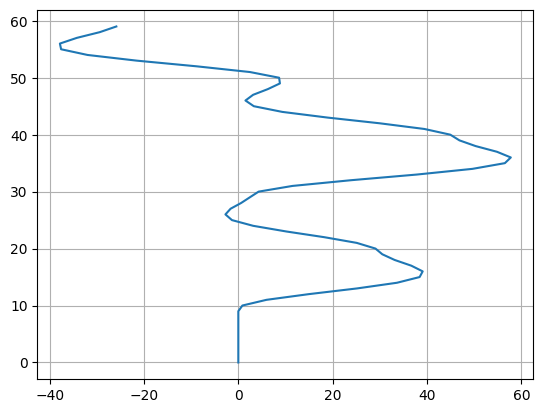

In [200]:
t_out_chr, y_closed_chr, x_out_chr = control.matlab.lsim(W_closed_chr_sensitivity, U=d, T=time_sim, X0=X0_chr)

plt.plot(t_out_chr, y_closed_chr)
plt.grid(True)

/usr/local/lib/python3.12/dist-packages/control/timeresp.py:1082: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


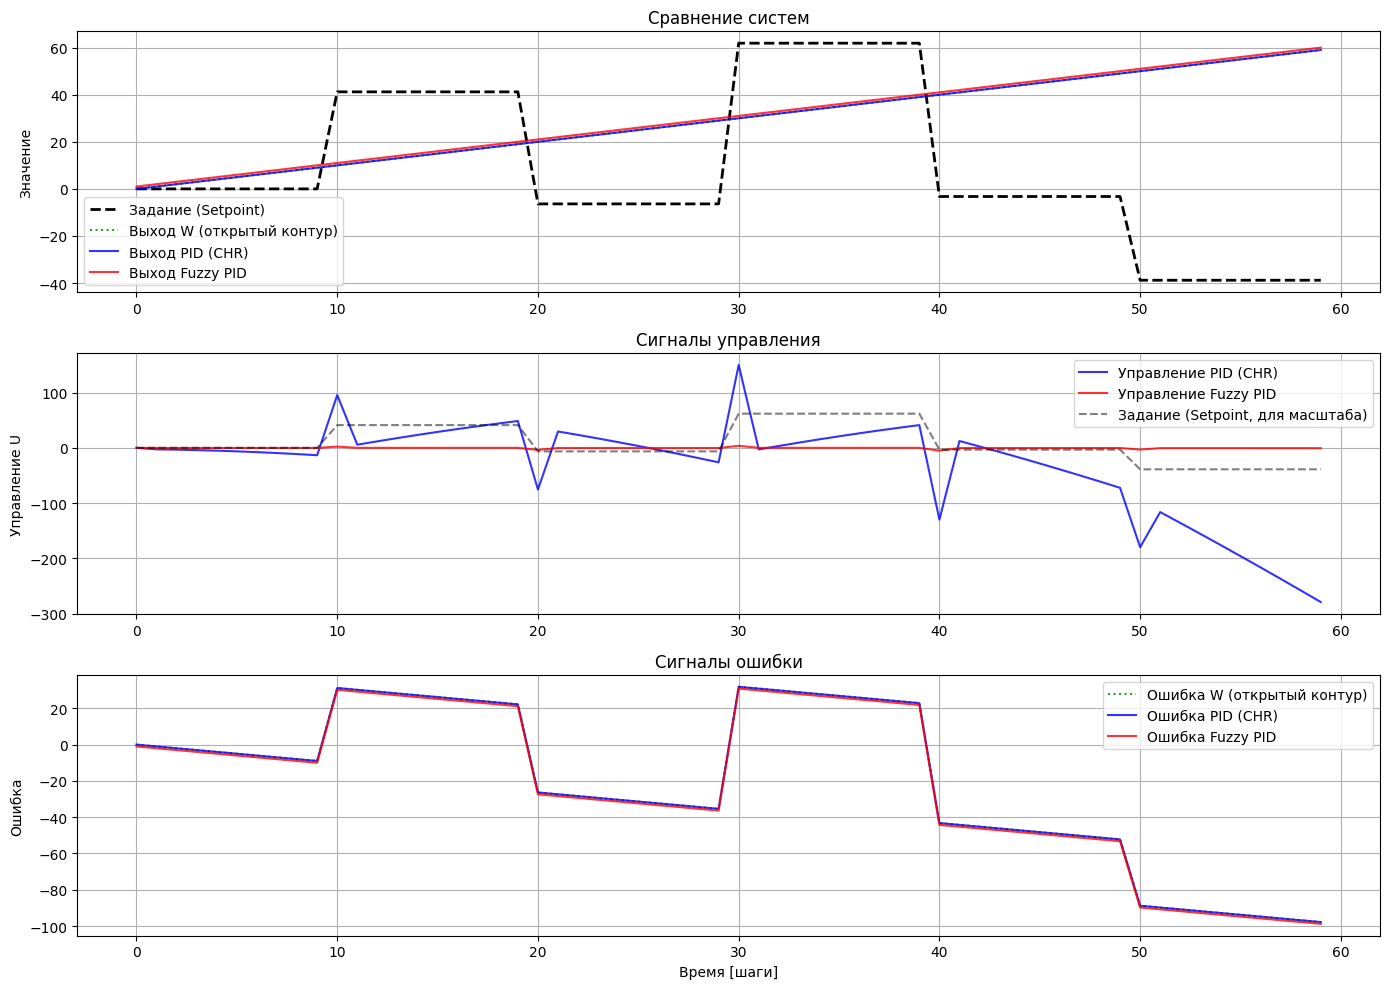


--- Сравнение производительности ---
Средняя абсолютная ошибка W (открытый контур): 38.422
Средняя абсолютная ошибка PID (CHR): 38.422
Средняя абсолютная ошибка Fuzzy PID: 38.755
Интеграл абсолютной ошибки W (открытый контур): 2256.394
Интеграл абсолютной ошибки PID (CHR): 2256.394
Интеграл абсолютной ошибки Fuzzy PID: 2275.394


In [191]:

# --- 2b. Симуляция замкнутой системы с нечетким PID ---
y_fuz_full = np.zeros_like(d)
u_fuz_full = np.zeros_like(d)
e_fuz_full = np.zeros_like(d)
eder_fuz_full = np.zeros_like(d)

# Начальные условия для моделирования
y_fuz_val = 0.0
e_prev_fuz = 0.0
esum_val_fuz = 0.0
# Инициализируем x_out_fuz перед циклом как вектор начальных условий для W
# Используем определенное ранее количество состояний
x_out_fuz = np.zeros(n_states_W_fuzzy) # Вектор начальных условий для системы W (форма (n_states_W_fuzzy,))

for i in range(len(d)):
    setpoint = d[i]
    # --- НЕЧЕТКИЙ PID ---
    erpid_fuz.setDesired(setpoint)
    error_fuz = setpoint - y_fuz_val # Ошибка: desired - current_output (исправлена строка)
    e_fuz_full[i] = error_fuz
    delta_error_fuz = error_fuz - e_prev_fuz
    eder_fuz_full[i] = delta_error_fuz / dt_sim if i > 0 else 0.0

    # Подаем значения в нечеткий регулятор
    # Используем один базовый экземпляр
    fpid_sim_base.input['ferr'] = error_fuz
    fpid_sim_base.input['fder'] = eder_fuz_full[i]
    try:
        fpid_sim_base.compute()
        modulation_factor = np.abs(fpid_sim_base.output['fout'])
    except:
        modulation_factor = 0.0 # Если нечеткий вывод не вычислен

    # Модулируем коэффициенты PID
    mod_kp = modulation_factor * kp_fuz
    mod_ki = modulation_factor * ki_fuz
    mod_kd = modulation_factor * kd_fuz
    erpid_fuz.setGains(mod_kp, mod_ki, mod_kd)

    # Рассчитываем управляющее воздействие (PID output)
    u_fuz_val = erpid_fuz.update(y_fuz_val)
    u_fuz_full[i] = u_fuz_val

    # --- Симуляция объекта W на один шаг ---
    # Используем только текущий момент времени и следующий для lsim
    t_step = time_sim[i:i+2] if i < len(time_sim) - 1 else np.array([time_sim[i], time_sim[i] + dt_sim])
    u_step = np.array([u_fuz_val, u_fuz_val]) # Управляющее воздействие постоянное на интервале шага

    # Используем последнее состояние из предыдущей итерации как X0
    # ГАРАНТИРУЕМ, что X0_fuz_step_local - плоский вектор (n_states_W_fuzzy,), а не столбец или другой размер
    # Приводим к ожидаемой размерности
    X0_fuz_step_local = np.atleast_1d(x_out_fuz.flatten())[:n_states_W_fuzzy]
    if X0_fuz_step_local.shape[0] != n_states_W_fuzzy:
        print(f"Предупреждение: Неожиданная размерность X0 на итерации {i+1}: {X0_fuz_step_local.shape}. Ожидается ({n_states_W_fuzzy},). Используем нули.")
        X0_fuz_step_local = np.zeros(n_states_W_fuzzy)

    try:
        # Симуляция системы W на малом интервале с постоянным u
        t_out_fuz_step, y_out_fuz_step, x_out_fuz = control.matlab.lsim(W, U=u_step, T=t_step, X0=X0_fuz_step_local)
        # Новый выход системы - последнее значение из симуляции шага
        y_fuz_val = y_out_fuz_step[-1]
        # x_out_fuz - это вектор/массив состояний на выходе lsim
        # Приведем его к правильной размерности (n_states_W_fuzzy,) для следующей итерации
        x_out_fuz = np.atleast_1d(x_out_fuz.flatten())[:n_states_W_fuzzy]
        if x_out_fuz.shape[0] != n_states_W_fuzzy:
             print(f"Предупреждение: Неожиданная размерность x_out на итерации {i+1}: {x_out_fuz.shape}. Ожидается ({n_states_W_fuzzy},). Используем нули.")
             x_out_fuz = np.zeros(n_states_W_fuzzy)

    except Exception as e_sim_step:
        print(f"Ошибка симуляции шага W для Fuzzy PID на итерации {i+1}: {e_sim_step}")
        y_fuz_val = y_fuz_full[i-1] if i > 0 else 0.0 # Используем предыдущее значение или 0
        # Если lsim не удался, x_out_fuz остается как есть, но следующая итерация может использовать старые/неправильные состояния
        # Лучше обнулить его для последующих итераций
        x_out_fuz = np.zeros(n_states_W_fuzzy)


    y_fuz_full[i] = y_fuz_val
    e_prev_fuz = error_fuz # Обновляем для следующей итерации
    esum_val_fuz += error_fuz * dt_sim # Интегрируем ошибку


# --- ВИЗУАЛИЗАЦИЯ ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# График 1: Выходы систем
axes[0].plot(time_sim, d, 'k--', label='Задание (Setpoint)', linewidth=2)
axes[0].plot(time_sim, y_open_loop, 'g:', label='Выход W (открытый контур)', alpha=0.8)
axes[0].plot(time_sim, y_closed_chr, 'b-', label='Выход PID (CHR)', alpha=0.8)
axes[0].plot(time_sim, y_fuz_full, 'r-', label='Выход Fuzzy PID', alpha=0.8)
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение систем')
axes[0].legend()
axes[0].grid(True)

# График 2: Сигналы управления
axes[1].plot(time_sim, u_chr_full, 'b-', label='Управление PID (CHR)', alpha=0.8)
axes[1].plot(time_sim, u_fuz_full, 'r-', label='Управление Fuzzy PID', alpha=0.8)
axes[1].plot(time_sim, d, 'k--', label='Задание (Setpoint, для масштаба)', alpha=0.5)
axes[1].set_ylabel('Управление U')
axes[1].set_title('Сигналы управления')
axes[1].legend()
axes[1].grid(True)

# График 3: Сигналы ошибки
error_open = d - y_open_loop
error_chr = d - y_closed_chr
error_fuz = d - y_fuz_full
axes[2].plot(time_sim, error_open, 'g:', label='Ошибка W (открытый контур)', alpha=0.8)
axes[2].plot(time_sim, error_chr, 'b-', label='Ошибка PID (CHR)', alpha=0.8)
axes[2].plot(time_sim, error_fuz, 'r-', label='Ошибка Fuzzy PID', alpha=0.8)
axes[2].set_ylabel('Ошибка')
axes[2].set_xlabel('Время [шаги]')
axes[2].set_title('Сигналы ошибки')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# --- ВЫВОД ПАРАМЕТРОВ ---
print("\n--- Сравнение производительности ---")
print(f"Средняя абсолютная ошибка W (открытый контур): {np.mean(np.abs(error_open)):.3f}")
print(f"Средняя абсолютная ошибка PID (CHR): {np.mean(np.abs(error_chr)):.3f}")
print(f"Средняя абсолютная ошибка Fuzzy PID: {np.mean(np.abs(error_fuz)):.3f}")
print(f"Интеграл абсолютной ошибки W (открытый контур): {np.trapezoid(np.abs(error_open), time_sim):.3f}")
print(f"Интеграл абсолютной ошибки PID (CHR): {np.trapezoid(np.abs(error_chr), time_sim):.3f}")
print(f"Интеграл абсолютной ошибки Fuzzy PID: {np.trapezoid(np.abs(error_fuz), time_sim):.3f}")